# Create Segmentation Dataset from Coral Bleaching Masks

This notebook processes the coral bleaching dataset to create a unified segmentation dataset suitable for semantic segmentation models.

**Input Data:**
- Original coral images (658 files)
- Bleached coral masks (binary)
- Non-bleached coral masks (binary)

**Output Data:**
- Original images (copied)
- Merged segmentation masks with 3 classes:
  - 0: Background (water/sand)
  - 1: Healthy coral
  - 2: Bleached coral

## 1. Setup and Data Loading

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
import shutil
from tqdm import tqdm
import json
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


In [10]:
# Define paths
DATA_DIR = Path('../data')
IMAGES_DIR = DATA_DIR / 'images'
BLEACHED_MASKS_DIR = DATA_DIR / 'masks_bleached'
NON_BLEACHED_MASKS_DIR = DATA_DIR / 'masks_non_bleached'

# Output directories for segmentation dataset
SEGMENTATION_DIR = DATA_DIR / 'segmentation'
SEG_IMAGES_DIR = SEGMENTATION_DIR / 'images'
SEG_MASKS_DIR = SEGMENTATION_DIR / 'masks'

# Create output directories
SEGMENTATION_DIR.mkdir(exist_ok=True)
SEG_IMAGES_DIR.mkdir(exist_ok=True)
SEG_MASKS_DIR.mkdir(exist_ok=True)

print(f"Created segmentation dataset structure:")
print(f"  Images: {SEG_IMAGES_DIR}")
print(f"  Masks: {SEG_MASKS_DIR}")

Created segmentation dataset structure:
  Images: ../data/segmentation/images
  Masks: ../data/segmentation/masks


In [11]:
# Load image file list (handling both .jpg and .JPG extensions)
jpg_files = sorted(list(IMAGES_DIR.glob('*.jpg')))
JPG_files = sorted(list(IMAGES_DIR.glob('*.JPG')))
image_files = jpg_files + JPG_files

print(f"Found {len(image_files)} images:")
print(f"  .jpg files: {len(jpg_files)}")
print(f"  .JPG files: {len(JPG_files)}")

# Create dataset mapping
dataset_info = []

for img_path in image_files:
    base_name = img_path.stem
    
    # Corresponding mask paths
    bleached_mask_path = BLEACHED_MASKS_DIR / f"{base_name}_bleached.png"
    non_bleached_mask_path = NON_BLEACHED_MASKS_DIR / f"{base_name}_non_bleached.png"
    
    # Check if all files exist
    if bleached_mask_path.exists() and non_bleached_mask_path.exists():
        dataset_info.append({
            'image_name': img_path.name,
            'base_name': base_name,
            'image_path': img_path,
            'bleached_mask_path': bleached_mask_path,
            'non_bleached_mask_path': non_bleached_mask_path,
            'extension': img_path.suffix
        })
    else:
        print(f"Warning: Missing masks for {img_path.name}")

dataset_df = pd.DataFrame(dataset_info)
print(f"\nComplete dataset: {len(dataset_df)} images with all masks available")
print(f"Extension breakdown:")
print(dataset_df['extension'].value_counts())

Found 658 images:
  .jpg files: 512
  .JPG files: 146

Complete dataset: 658 images with all masks available
Extension breakdown:
extension
.jpg    512
.JPG    146
Name: count, dtype: int64


## 2. Mask Merging Logic

In [12]:
def merge_masks(bleached_mask_path, non_bleached_mask_path):
    """
    Merge bleached and non-bleached masks into a single segmentation mask.
    
    Returns:
        merged_mask: numpy array with values:
            0 = background
            1 = healthy coral (non-bleached)
            2 = bleached coral
    """
    # Load masks
    bleached_mask = cv2.imread(str(bleached_mask_path), cv2.IMREAD_GRAYSCALE)
    non_bleached_mask = cv2.imread(str(non_bleached_mask_path), cv2.IMREAD_GRAYSCALE)
    
    if bleached_mask is None or non_bleached_mask is None:
        raise ValueError(f"Could not load masks: {bleached_mask_path}, {non_bleached_mask_path}")
    
    # Ensure masks have the same dimensions
    if bleached_mask.shape != non_bleached_mask.shape:
        raise ValueError(f"Mask dimensions don't match: {bleached_mask.shape} vs {non_bleached_mask.shape}")
    
    # Create merged mask (start with all zeros = background)
    merged_mask = np.zeros_like(bleached_mask, dtype=np.uint8)
    
    # Set healthy coral pixels (value = 1)
    merged_mask[non_bleached_mask > 127] = 1
    
    # Set bleached coral pixels (value = 2, overwrites healthy if overlap)
    merged_mask[bleached_mask > 127] = 2
    
    return merged_mask

def get_mask_statistics(mask):
    """
    Calculate statistics for a segmentation mask.
    """
    total_pixels = mask.size
    background_pixels = np.sum(mask == 0)
    healthy_pixels = np.sum(mask == 1)
    bleached_pixels = np.sum(mask == 2)
    
    return {
        'total_pixels': total_pixels,
        'background_pixels': background_pixels,
        'healthy_pixels': healthy_pixels,
        'bleached_pixels': bleached_pixels,
        'background_percentage': (background_pixels / total_pixels) * 100,
        'healthy_percentage': (healthy_pixels / total_pixels) * 100,
        'bleached_percentage': (bleached_pixels / total_pixels) * 100,
        'coral_percentage': ((healthy_pixels + bleached_pixels) / total_pixels) * 100
    }

# Test the merging function on a sample
sample_idx = 0
sample_row = dataset_df.iloc[sample_idx]

print(f"Testing mask merging on: {sample_row['image_name']}")
merged_mask = merge_masks(sample_row['bleached_mask_path'], sample_row['non_bleached_mask_path'])
stats = get_mask_statistics(merged_mask)

print(f"Merged mask shape: {merged_mask.shape}")
print(f"Unique values: {np.unique(merged_mask)}")
print(f"Class distribution:")
print(f"  Background: {stats['background_percentage']:.2f}%")
print(f"  Healthy coral: {stats['healthy_percentage']:.2f}%")
print(f"  Bleached coral: {stats['bleached_percentage']:.2f}%")

Testing mask merging on: C10_BC_PM_T1_29nov24_CDaza_corr.jpg
Merged mask shape: (2421, 3209)
Unique values: [0 1 2]
Class distribution:
  Background: 32.64%
  Healthy coral: 56.17%
  Bleached coral: 11.19%


## 3. Visualization of Merged Masks

Examples of mask merging:


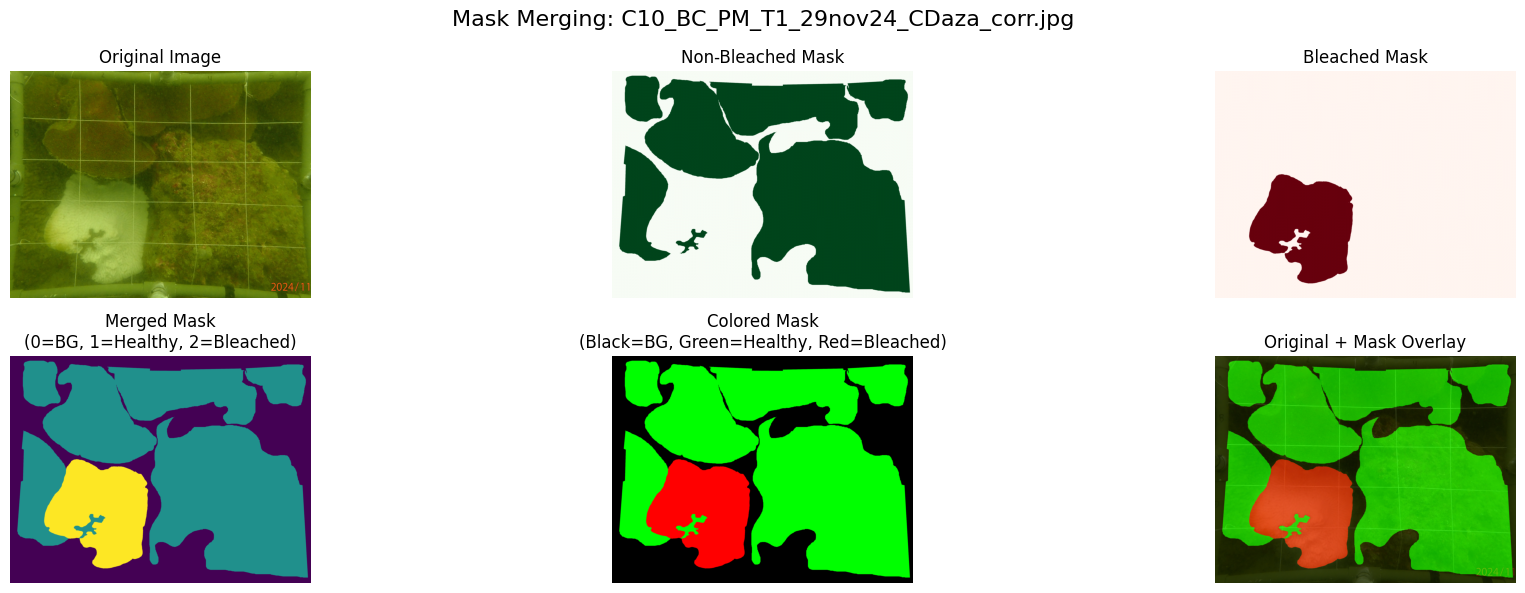

Statistics for C10_BC_PM_T1_29nov24_CDaza_corr.jpg:
  Background: 32.6%
  Healthy coral: 56.2%
  Bleached coral: 11.2%
  Total coral: 67.4%



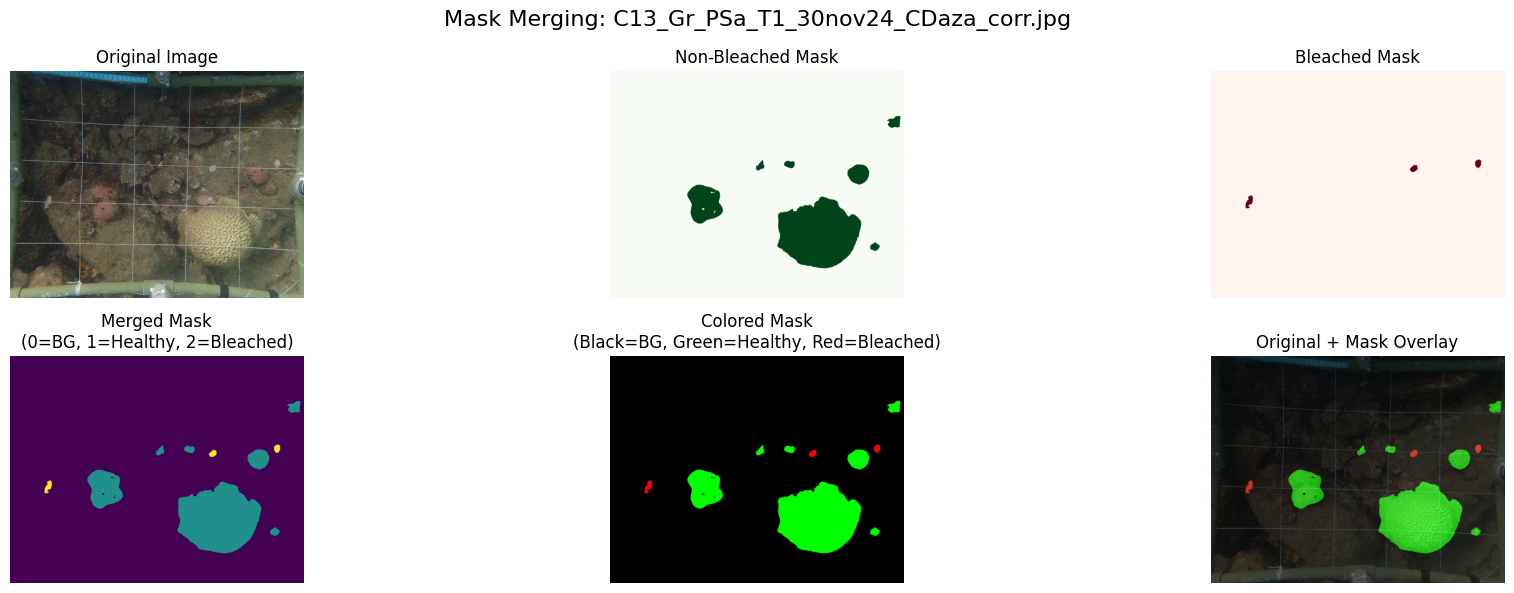

Statistics for C13_Gr_PSa_T1_30nov24_CDaza_corr.jpg:
  Background: 91.0%
  Healthy coral: 8.8%
  Bleached coral: 0.2%
  Total coral: 9.0%



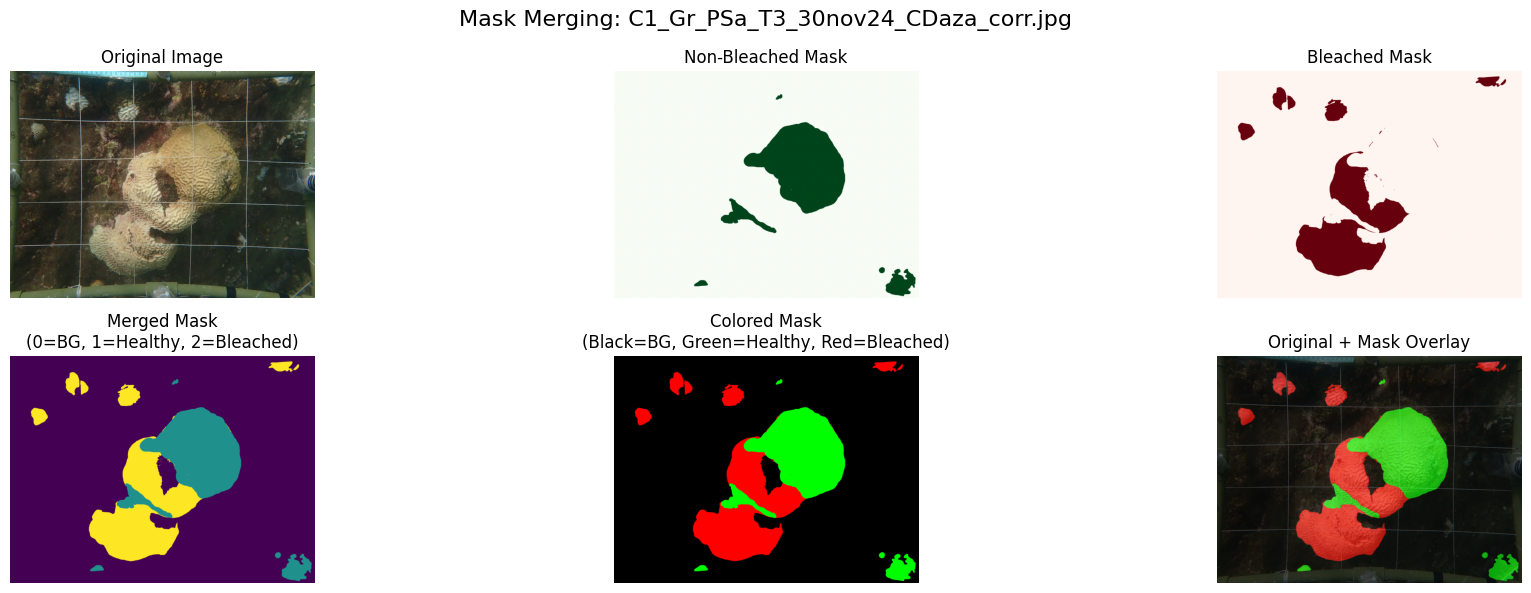

Statistics for C1_Gr_PSa_T3_30nov24_CDaza_corr.jpg:
  Background: 80.2%
  Healthy coral: 9.6%
  Bleached coral: 10.2%
  Total coral: 19.8%



In [13]:
def visualize_mask_merging(idx, figsize=(20, 6)):
    """
    Visualize the mask merging process for a specific image.
    """
    row = dataset_df.iloc[idx]
    
    # Load original image
    img = cv2.imread(str(row['image_path']))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Load individual masks
    bleached_mask = cv2.imread(str(row['bleached_mask_path']), cv2.IMREAD_GRAYSCALE)
    non_bleached_mask = cv2.imread(str(row['non_bleached_mask_path']), cv2.IMREAD_GRAYSCALE)
    
    # Create merged mask
    merged_mask = merge_masks(row['bleached_mask_path'], row['non_bleached_mask_path'])
    
    # Create colored version of merged mask for visualization
    colored_mask = np.zeros((merged_mask.shape[0], merged_mask.shape[1], 3), dtype=np.uint8)
    colored_mask[merged_mask == 0] = [0, 0, 0]      # Background: black
    colored_mask[merged_mask == 1] = [0, 255, 0]    # Healthy: green
    colored_mask[merged_mask == 2] = [255, 0, 0]    # Bleached: red
    
    # Create overlay
    alpha = 0.6
    overlay = cv2.addWeighted(img, 1-alpha, colored_mask, alpha, 0)
    
    # Plot everything
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    
    # Top row: original masks
    axes[0, 0].imshow(img)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(non_bleached_mask, cmap='Greens')
    axes[0, 1].set_title('Non-Bleached Mask')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(bleached_mask, cmap='Reds')
    axes[0, 2].set_title('Bleached Mask')
    axes[0, 2].axis('off')
    
    # Bottom row: merged results
    axes[1, 0].imshow(merged_mask, cmap='viridis')
    axes[1, 0].set_title('Merged Mask\n(0=BG, 1=Healthy, 2=Bleached)')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(colored_mask)
    axes[1, 1].set_title('Colored Mask\n(Black=BG, Green=Healthy, Red=Bleached)')
    axes[1, 1].axis('off')
    
    axes[1, 2].imshow(overlay)
    axes[1, 2].set_title('Original + Mask Overlay')
    axes[1, 2].axis('off')
    
    plt.suptitle(f'Mask Merging: {row["image_name"]}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    stats = get_mask_statistics(merged_mask)
    print(f"Statistics for {row['image_name']}:")
    print(f"  Background: {stats['background_percentage']:.1f}%")
    print(f"  Healthy coral: {stats['healthy_percentage']:.1f}%")
    print(f"  Bleached coral: {stats['bleached_percentage']:.1f}%")
    print(f"  Total coral: {stats['coral_percentage']:.1f}%")
    print()

# Visualize a few examples
print("Examples of mask merging:")
for i in range(3):
    visualize_mask_merging(i * 50)  # Show every 50th image for variety

## 4. Process All Images and Create Segmentation Dataset

In [19]:
SEG_MASKS_DIR

PosixPath('../data/segmentation/masks')

In [20]:
# Process all images and create the segmentation dataset
processing_stats = []
failed_images = []

print(f"Processing {len(dataset_df)} images...")

for idx, row in tqdm(dataset_df.iterrows(), total=len(dataset_df), desc="Creating segmentation dataset"):
    try:
        # Define output paths
        # Use .jpg extension for all output images for consistency
        output_image_name = f"{row['base_name']}.jpg"
        output_mask_name = f"{row['base_name']}.png"
        
        output_image_path = SEG_IMAGES_DIR / output_image_name
        output_mask_path = SEG_MASKS_DIR / output_mask_name
        
        # Copy original image (convert to consistent format)
        img = cv2.imread(str(row['image_path']))
        cv2.imwrite(str(output_image_path), img)
        
        # Create and save merged mask
        merged_mask = merge_masks(row['bleached_mask_path'], row['non_bleached_mask_path'])
        colored_mask = np.zeros((merged_mask.shape[0], merged_mask.shape[1], 3))
        colored_mask[merged_mask == 0] = [0, 0, 0]      # Background: black
        colored_mask[merged_mask == 1] = [255, 255, 255]    # Healthy: green
        colored_mask[merged_mask == 2] = [255, 255, 255]    # Bleached: red
        cv2.imwrite(str(output_mask_path), colored_mask,)
        
        # Collect statistics
        stats = get_mask_statistics(merged_mask)
        stats['image_name'] = output_image_name
        stats['mask_name'] = output_mask_name
        stats['original_extension'] = row['extension']
        processing_stats.append(stats)
        
    except Exception as e:
        print(f"Failed to process {row['image_name']}: {e}")
        failed_images.append(row['image_name'])

print(f"\nProcessing complete!")
print(f"Successfully processed: {len(processing_stats)} images")
print(f"Failed: {len(failed_images)} images")

if failed_images:
    print(f"Failed images: {failed_images}")

# Create statistics DataFrame
stats_df = pd.DataFrame(processing_stats)
print(f"\nDataset creation statistics:")
print(f"Output images saved to: {SEG_IMAGES_DIR}")
print(f"Output masks saved to: {SEG_MASKS_DIR}")

Processing 658 images...


Creating segmentation dataset: 100%|██████████| 658/658 [04:02<00:00,  2.72it/s]


Processing complete!
Successfully processed: 658 images
Failed: 0 images

Dataset creation statistics:
Output images saved to: ../data/segmentation/images
Output masks saved to: ../data/segmentation/masks


## 5. Dataset Quality Validation and Analysis

=== SEGMENTATION DATASET ANALYSIS ===
Total images: 658
Total masks: 658

Class Distribution Statistics:
       background_percentage  healthy_percentage  bleached_percentage  \
count             658.000000          658.000000           658.000000   
mean               65.596957           24.600306             9.802737   
std                24.498106           20.723949            14.732345   
min                11.633855            0.000000             0.000000   
25%                45.834619            5.941827             0.163579   
50%                65.474642           20.654500             3.325609   
75%                87.216302           39.068861            13.101977   
max               100.000000           87.722733            81.466138   

       coral_percentage  
count        658.000000  
mean          34.403043  
std           24.498106  
min            0.000000  
25%           12.783698  
50%           34.525358  
75%           54.165381  
max           88.366145  

Ov

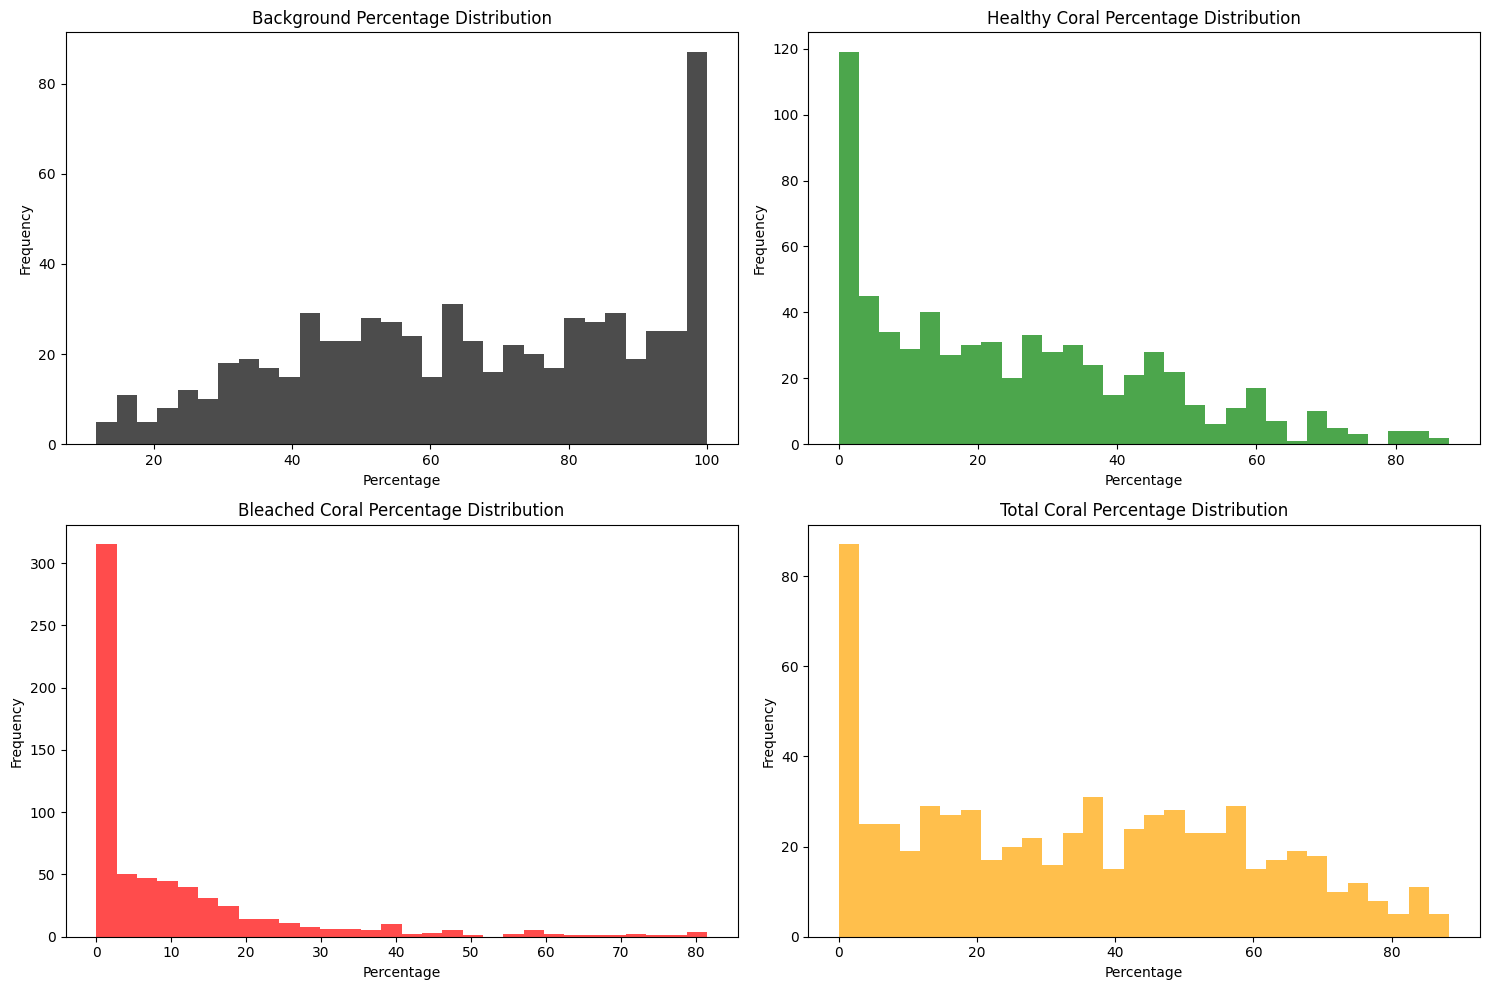

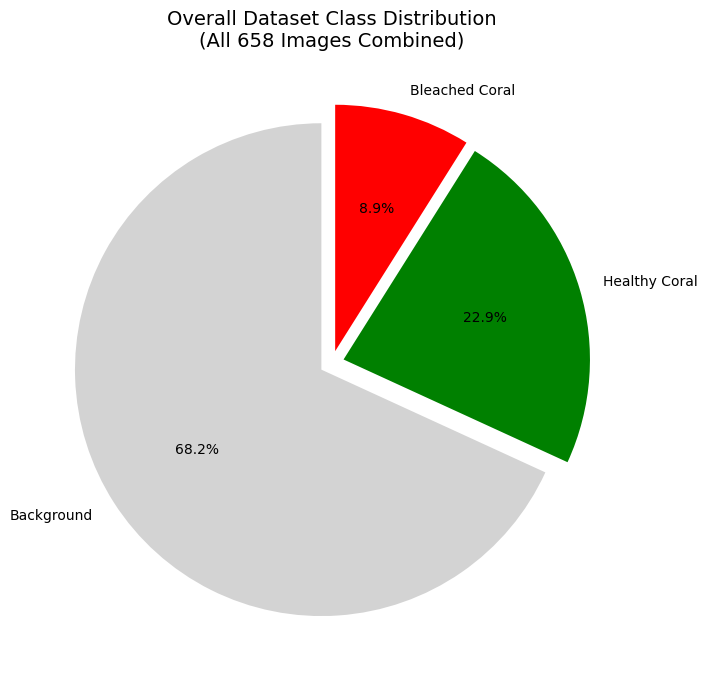

In [8]:
# Analyze the created dataset
print("=== SEGMENTATION DATASET ANALYSIS ===")
print(f"Total images: {len(stats_df)}")
print(f"Total masks: {len(stats_df)}")

# Class distribution statistics
print("\nClass Distribution Statistics:")
class_stats = stats_df[['background_percentage', 'healthy_percentage', 'bleached_percentage', 'coral_percentage']].describe()
print(class_stats)

# Overall dataset composition
total_pixels = stats_df['total_pixels'].sum()
total_background = stats_df['background_pixels'].sum()
total_healthy = stats_df['healthy_pixels'].sum()
total_bleached = stats_df['bleached_pixels'].sum()

print(f"\nOverall Dataset Composition:")
print(f"Background pixels: {total_background:,} ({total_background/total_pixels*100:.1f}%)")
print(f"Healthy coral pixels: {total_healthy:,} ({total_healthy/total_pixels*100:.1f}%)")
print(f"Bleached coral pixels: {total_bleached:,} ({total_bleached/total_pixels*100:.1f}%)")
print(f"Total coral pixels: {total_healthy + total_bleached:,} ({(total_healthy + total_bleached)/total_pixels*100:.1f}%)")

# Visualize class distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Class percentage distributions
axes[0, 0].hist(stats_df['background_percentage'], bins=30, alpha=0.7, color='black')
axes[0, 0].set_title('Background Percentage Distribution')
axes[0, 0].set_xlabel('Percentage')
axes[0, 0].set_ylabel('Frequency')

axes[0, 1].hist(stats_df['healthy_percentage'], bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Healthy Coral Percentage Distribution')
axes[0, 1].set_xlabel('Percentage')
axes[0, 1].set_ylabel('Frequency')

axes[1, 0].hist(stats_df['bleached_percentage'], bins=30, alpha=0.7, color='red')
axes[1, 0].set_title('Bleached Coral Percentage Distribution')
axes[1, 0].set_xlabel('Percentage')
axes[1, 0].set_ylabel('Frequency')

axes[1, 1].hist(stats_df['coral_percentage'], bins=30, alpha=0.7, color='orange')
axes[1, 1].set_title('Total Coral Percentage Distribution')
axes[1, 1].set_xlabel('Percentage')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create overall pie chart
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
labels = ['Background', 'Healthy Coral', 'Bleached Coral']
sizes = [total_background, total_healthy, total_bleached]
colors = ['lightgray', 'green', 'red']
explode = (0.05, 0.05, 0.05)

ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, explode=explode)
ax.set_title('Overall Dataset Class Distribution\n(All 658 Images Combined)', fontsize=14)
plt.show()

## 6. Create Train/Validation Splits

In [ ]:
# Create train/validation splits
train_ratio = 0.8
val_ratio = 0.2
random_state = 42

# Split the dataset
train_data, val_data = train_test_split(
    stats_df, 
    test_size=val_ratio, 
    random_state=random_state,
    stratify=None  # Could stratify by coral_percentage if needed
)

print(f"Dataset splits:")
print(f"Training set: {len(train_data)} images ({len(train_data)/len(stats_df)*100:.1f}%)")
print(f"Validation set: {len(val_data)} images ({len(val_data)/len(stats_df)*100:.1f}%)")

# Analyze split balance
print("\nSplit Balance Analysis:")
print("Training set class distribution:")
train_bg = train_data['background_percentage'].mean()
train_healthy = train_data['healthy_percentage'].mean()
train_bleached = train_data['bleached_percentage'].mean()
print(f"  Background: {train_bg:.1f}%")
print(f"  Healthy coral: {train_healthy:.1f}%")
print(f"  Bleached coral: {train_bleached:.1f}%")

print("\nValidation set class distribution:")
val_bg = val_data['background_percentage'].mean()
val_healthy = val_data['healthy_percentage'].mean()
val_bleached = val_data['bleached_percentage'].mean()
print(f"  Background: {val_bg:.1f}%")
print(f"  Healthy coral: {val_healthy:.1f}%")
print(f"  Bleached coral: {val_bleached:.1f}%")

# Save split information
split_info = {
    'total_images': len(stats_df),
    'train_images': len(train_data),
    'val_images': len(val_data),
    'train_ratio': train_ratio,
    'val_ratio': val_ratio,
    'random_state': random_state,
    'train_files': train_data[['image_name', 'mask_name']].to_dict('records'),
    'val_files': val_data[['image_name', 'mask_name']].to_dict('records')
}

# Save split information to JSON
split_file = SEGMENTATION_DIR / 'dataset_splits.json'
with open(split_file, 'w') as f:
    json.dump(split_info, f, indent=2)

print(f"\nDataset split information saved to: {split_file}")

# Save detailed statistics
stats_file = SEGMENTATION_DIR / 'dataset_statistics.csv'
stats_df.to_csv(stats_file, index=False)
print(f"Detailed statistics saved to: {stats_file}")

## 7. Dataset Summary and Usage Instructions

In [ ]:
# Final verification - check a few random samples
print("=== FINAL VERIFICATION ===")
verification_samples = np.random.choice(len(stats_df), 3, replace=False)

for i, idx in enumerate(verification_samples):
    row = stats_df.iloc[idx]
    
    # Check if files exist
    img_path = SEG_IMAGES_DIR / row['image_name']
    mask_path = SEG_MASKS_DIR / row['mask_name']
    
    img_exists = img_path.exists()
    mask_exists = mask_path.exists()
    
    print(f"Sample {i+1}: {row['image_name']}")
    print(f"  Image exists: {img_exists}")
    print(f"  Mask exists: {mask_exists}")
    
    if img_exists and mask_exists:
        # Verify mask values
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        unique_values = np.unique(mask)
        print(f"  Mask values: {unique_values}")
        print(f"  Expected values: [0, 1, 2] or subset")
        print(f"  Valid: {set(unique_values).issubset({0, 1, 2})}")
    print()

print("\n" + "="*80)
print("SEGMENTATION DATASET CREATION COMPLETE!")
print("="*80)

print(f"\n📁 Dataset Location: {SEGMENTATION_DIR}")
print(f"   📷 Images: {SEG_IMAGES_DIR} ({len(list(SEG_IMAGES_DIR.glob('*.jpg')))} files)")
print(f"   🎭 Masks: {SEG_MASKS_DIR} ({len(list(SEG_MASKS_DIR.glob('*.png')))} files)")

print(f"\n📊 Class Labels:")
print(f"   0 = Background (water/sand)")
print(f"   1 = Healthy coral")
print(f"   2 = Bleached coral")

print(f"\n📈 Dataset Statistics:")
print(f"   Total images: {len(stats_df)}")
print(f"   Training set: {len(train_data)} images")
print(f"   Validation set: {len(val_data)} images")
print(f"   Average coral coverage: {stats_df['coral_percentage'].mean():.1f}%")
print(f"   Class balance: {total_background/total_pixels*100:.1f}% BG, {total_healthy/total_pixels*100:.1f}% Healthy, {total_bleached/total_pixels*100:.1f}% Bleached")

print(f"\n🔧 Usage for PyTorch/TensorFlow:")
print(f"   - Load images from: data/segmentation/images/")
print(f"   - Load masks from: data/segmentation/masks/")
print(f"   - Use dataset_splits.json for train/val splits")
print(f"   - Mask values: 0=background, 1=healthy, 2=bleached")
print(f"   - Recommended models: U-Net, DeepLabV3, SegNet")

print(f"\n✨ Ready for semantic segmentation training!")
print("="*80)